## 3.2 autograd

用Tensor訓練網路很方便，但從上一小節最後的線性回歸例子來看，反向傳播過程需要手動實現。這對於像線性回歸等較為簡單的模型來說，還可以應付，但實際使用中經常出現非常複雜的網路結構，此時如果手動實現反向傳播，不僅費時費力，而且容易出錯，難以檢查。torch.autograd就是為方便用戶使用，而專門開發的一套自動求導引擎，它能夠根據輸入和前向傳播過程自動構建計算圖，並執行反向傳播。

計算圖(Computation Graph)是現代深度學習框架如PyTorch和TensorFlow等的核心，其為高效自動求導演算法——反向傳播(Back Propogation)提供了理論支援，瞭解計算圖在實際寫程式過程中會有極大的幫助。本節將涉及一些基礎的計算圖知識，但並不要求讀者事先對此有深入的瞭解。關於計算圖的基礎知識推薦閱讀Christopher Olah的文章[^1]。

[^1]: http://colah.github.io/posts/2015-08-Backprop/


### 3.2.1 Variable
PyTorch在autograd模組中實現了計算圖的相關功能，autograd中的核心資料結構是Variable。Variable封裝了tensor，並記錄對tensor的操作記錄用來構建計算圖。Variable的資料結構如圖3-2所示，主要包含三個屬性：

- `data`：保存variable所包含的tensor
- `grad`：保存`data`對應的梯度，`grad`也是variable，而不是tensor，它與`data`形狀一致。 
- `grad_fn`： 指向一個`Function`，記錄tensor的操作歷史，即它是什麼操作的輸出，用來構建計算圖。如果某一個變數是由使用者創建，則它為葉子節點，對應的grad_fn等於None。


![圖3-2:Variable資料結構](imgs/autograd_Variable.png)

Variable的構造函數需要傳入tensor，同時有兩個可選參數：
- `requires_grad (bool)`：是否需要對該variable進行求導
- `volatile (bool)`：意為”揮發“，設置為True，則構建在該variable之上的圖都不會求導，專為推理階段設計

Variable提供了大部分tensor支援的函數，但其不支援部分`inplace`函數，因這些函數會修改tensor自身，而在反向傳播中，variable需要緩存原來的tensor來計算反向傳播梯度。如果想要計算各個Variable的梯度，只需調用根節點variable的`backward`方法，autograd會自動沿著計算圖反向傳播，計算每一個葉子節點的梯度。

`variable.backward(grad_variables=None, retain_graph=None, create_graph=None)`主要有如下參數：

- grad_variables：形狀與variable一致，對於`y.backward()`，grad_variables相當於鏈式法則${dz \over dx}={dz \over dy} \times {dy \over dx}$中的$\textbf {dz} \over \textbf {dy}$。grad_variables也可以是tensor或序列。
- retain_graph：反向傳播需要緩存一些中間結果，反向傳播之後，這些緩存就被清空，可通過指定這個參數不清空緩存，用來多次反向傳播。
- create_graph：對反向傳播過程再次構建計算圖，可通過`backward of backward`實現求高階導數。

上述描述可能比較抽象，如果沒有看懂，不用著急，會在本節後半部分詳細介紹，下面先看幾個例子。

In [1]:
from __future__ import print_function
import torch as t
from torch.autograd import Variable as V

In [2]:
# 從tensor中創建variable，指定需要求導
a = V(t.ones(3,4), requires_grad = True) 
a

Variable containing:
 1  1  1  1
 1  1  1  1
 1  1  1  1
[torch.FloatTensor of size 3x4]

In [3]:
b = V(t.zeros(3,4))
b

Variable containing:
 0  0  0  0
 0  0  0  0
 0  0  0  0
[torch.FloatTensor of size 3x4]

In [4]:
# 函數的使用與tensor一致
# 也可寫成c = a + b
c = a.add(b)
c

Variable containing:
 1  1  1  1
 1  1  1  1
 1  1  1  1
[torch.FloatTensor of size 3x4]

In [5]:
d = c.sum()
d.backward() # 反向傳播

In [6]:
# 注意二者的區別
# 前者在取data後變為tensor，而後從tensor計算sum得到float
# 後者計算sum後仍然是Variable
c.data.sum(), c.sum()

(12.0, Variable containing:
  12
 [torch.FloatTensor of size 1])

In [7]:
a.grad

Variable containing:
 1  1  1  1
 1  1  1  1
 1  1  1  1
[torch.FloatTensor of size 3x4]

In [8]:
# 此處雖然沒有指定c需要求導，但c依賴於a，而a需要求導，
# 因此c的requires_grad屬性會自動設為True
a.requires_grad, b.requires_grad, c.requires_grad

(True, False, True)

In [9]:
# 由用戶創建的variable屬於葉子節點，對應的grad_fn是None
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [10]:
# c.grad是None, 因c不是葉子節點，它的梯度是用來計算a的梯度
# 所以雖然c.requires_grad = True,但其梯度計算完之後即被釋放
c.grad is None

True

計算下面這個函數的導函數：
$$
y = x^2\bullet e^x
$$
它的導函數是：
$$
{dy \over dx} = 2x\bullet e^x + x^2 \bullet e^x
$$
來看看autograd的計算結果與手動求導計算結果的誤差。

In [11]:
def f(x):
    '''計算y'''
    y = x**2 * t.exp(x)
    return y

def gradf(x):
    '''手動求導函數'''
    dx = 2*x*t.exp(x) + x**2*t.exp(x)
    return dx

In [12]:
x = V(t.randn(3,4), requires_grad = True)
y = f(x)
y

Variable containing:
  7.8454   0.4475   5.5884   0.1406
  0.4044   0.5008   0.4989  13.3268
  0.3547   0.0623   1.0497   4.2674
[torch.FloatTensor of size 3x4]

In [13]:
y.backward(t.ones(y.size())) # grad_variables形狀與y一致
x.grad

Variable containing:
 19.0962   2.1796  14.4631   1.0203
 -0.3276   0.1172  -0.1745  29.7573
  1.8619  -0.3699   3.9812  11.6386
[torch.FloatTensor of size 3x4]

In [14]:
# autograd的計算結果與利用公式手動計算的結果一致
gradf(x) 

Variable containing:
 19.0962   2.1796  14.4631   1.0203
 -0.3276   0.1172  -0.1745  29.7573
  1.8619  -0.3699   3.9812  11.6386
[torch.FloatTensor of size 3x4]

### 3.2.2 計算圖

PyTorch中`autograd`的底層採用了計算圖，計算圖是一種特殊的有向無環圖（DAG），用於記錄運算元與變數之間的關係。一般用矩形表示運算元，橢圓形表示變數。如運算式$ \textbf {z = wx + b}$可分解為$\textbf{y = wx}$和$\textbf{z = y + b}$，其計算圖如圖3-3所示，圖中`MUL`，`ADD`都是運算元，$\textbf{w}$，$\textbf{x}$，$\textbf{b}$即變數。

![圖3-3:computation graph](imgs/com_graph.svg)

如上有向無環圖中，$\textbf{X}$和$\textbf{b}$是葉子節點（leaf node），這些節點通常由用戶自己創建，不依賴於其他變數。$\textbf{z}$稱為根節點，是計算圖的最終目標。利用鏈式法則很容易求得各個葉子節點的梯度。
$${\partial z \over \partial b} = 1,\space {\partial z \over \partial y} = 1\\
{\partial y \over \partial w }= x,{\partial y \over \partial x}= w\\
{\partial z \over \partial x}= {\partial z \over \partial y} {\partial y \over \partial x}=1 * w\\
{\partial z \over \partial w}= {\partial z \over \partial y} {\partial y \over \partial w}=1 * x\\
$$
而有了計算圖，上述鏈式求導即可利用計算圖的反向傳播自動完成，其過程如圖3-4所示。

![圖3-4：計算圖的反向傳播](imgs/com_graph_backward.svg)


在PyTorch實現中，autograd會隨著使用者的操作，記錄生成當前variable的所有操作，並由此建立一個有向無環圖。用戶每進行一個操作，相應的計算圖就會發生改變。更底層的實現中，圖中記錄了操作`Function`，每一個變數在圖中的位置可通過其`grad_fn`屬性在圖中的位置推測得到。在反向傳播過程中，autograd沿著這個圖從當前變數（根節點$\textbf{z}$）溯源，可以利用鏈式求導法則計算所有葉子節點的梯度。每一個前向傳播操作的函數都有與之對應的反向傳播函數用來計算輸入的各個variable的梯度，這些函數的函數名通常以`Backward`結尾。下面結合代碼學習autograd的實現細節。

In [15]:
x = V(t.ones(1))
b = V(t.rand(1), requires_grad = True)
w = V(t.rand(1), requires_grad = True)
y = w * x # 等價於y=w.mul(x)
z = y + b # 等價於z=y.add(b)

In [16]:
x.requires_grad, b.requires_grad, w.requires_grad

(False, True, True)

In [17]:
# 雖然未指定y.requires_grad為True，但由於y依賴於需要求導的w
# 故而y.requires_grad為True
y.requires_grad

True

In [18]:
x.is_leaf, w.is_leaf, b.is_leaf

(True, True, True)

In [19]:
y.is_leaf, z.is_leaf

(False, False)

In [20]:
# grad_fn可以查看這個variable的反向傳播函數，
# z是add函數的輸出，所以它的反向傳播函數是AddBackward
z.grad_fn 

In [21]:
# next_functions保存grad_fn的輸入，是一個tuple，tuple的元素也是Function
# 第一個是y，它是乘法(mul)的輸出，所以對應的反向傳播函數y.grad_fn是MulBackward
# 第二個是b，它是葉子節點，由用戶創建，grad_fn為None，但是有
z.grad_fn.next_functions 

((<MulBackward1 at 0x7f7ea53d8cf8>, 0),
 (<AccumulateGrad at 0x7f7ea53d8e80>, 0))

In [22]:
# variable的grad_fn對應著和圖中的function相對應
z.grad_fn.next_functions[0][0] == y.grad_fn

True

In [23]:
# 第一個是w，葉子節點，需要求導，梯度是累加的
# 第二個是x，葉子節點，不需要求導，所以為None
y.grad_fn.next_functions

((<AccumulateGrad at 0x7f7ea53d8a58>, 0), (None, 0))

In [24]:
# 葉子節點的grad_fn是None
w.grad_fn,x.grad_fn

(None, None)

計算w的梯度的時候，需要用到x的數值(${\partial y\over \partial w} = x $)，這些數值在前向過程中會保存成buffer，在計算完梯度之後會自動清空。為了能夠多次反向傳播需要指定`retain_graph`來保留這些buffer。

In [25]:
# 使用retain_graph來保存buffer
z.backward(retain_graph=True)
w.grad

Variable containing:
 1
[torch.FloatTensor of size 1]

In [26]:
# 多次反向傳播，梯度累加，這也就是w中AccumulateGrad標識的含義
z.backward()
w.grad

Variable containing:
 2
[torch.FloatTensor of size 1]

PyTorch使用的是動態圖，它的計算圖在每次前向傳播時都是從頭開始構建，所以它能夠使用Python控制語句（如for、if等）根據需求創建計算圖。這點在自然語言處理領域中很有用，它意味著你不需要事先構建所有可能用到的圖的路徑，圖在運行時才構建。

In [27]:
def abs(x):
    if x.data[0]>0: return x
    else: return -x
x = V(t.ones(1),requires_grad=True)
y = abs(x)
y.backward()
x.grad

Variable containing:
 1
[torch.FloatTensor of size 1]

In [28]:
x = V(-1*t.ones(1),requires_grad=True)
y = abs(x)
y.backward()
print(x.grad)

Variable containing:
-1
[torch.FloatTensor of size 1]



In [29]:
def f(x):
    result = 1
    for ii in x:
        if ii.data[0]>0: result=ii*result
    return result
x = V(t.arange(-2,4),requires_grad=True)
y = f(x) # y = x[3]*x[4]*x[5]
y.backward()
x.grad

Variable containing:
 0
 0
 0
 6
 3
 2
[torch.FloatTensor of size 6]

變數的`requires_grad`屬性預設為False，如果某一個節點requires_grad被設置為True，那麼所有依賴它的節點`requires_grad`都是True。這其實很好理解，對於$ \textbf{x}\to \textbf{y} \to \textbf{z}$，x.requires_grad = True，當需要計算$\partial z \over \partial x$時，根據鏈式法則，$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$，自然也需要求$ \frac{\partial z}{\partial y}$，所以y.requires_grad會被自動標為True. 

`volatile=True`是另外一個很重要的標識，它能夠將所有依賴於它的節點全部都設為`volatile=True`，其優先順序比`requires_grad=True`高。`volatile=True`的節點不會求導，即使`requires_grad=True`，也無法進行反向傳播。對於不需要反向傳播的情景（如inference，即測試推理時），該參數可實現一定程度的速度提升，並節省約一半顯存，因其不需要分配空間計算梯度。

In [30]:
x = V(t.ones(1))
w = V(t.rand(1), requires_grad=True)
y = x * w
# y依賴於w，而w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

(False, True, True)

In [31]:
x = V(t.ones(1), volatile=True)
w = V(t.rand(1), requires_grad = True)
y = x * w
# y依賴於w和x，但x.volatile = True，w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

(False, True, False)

In [32]:
x.volatile, w.volatile, y.volatile

(True, False, True)

在反向傳播過程中非葉子節點的導數計算完之後即被清空。若想查看這些變數的梯度，有兩種方法：
- 使用autograd.grad函數
- 使用hook

`autograd.grad`和`hook`方法都是很強大的工具，更詳細的用法參考官方api文檔，這裡舉例說明基礎的使用。推薦使用`hook`方法，但是在實際使用中應儘量避免修改grad的值。

In [33]:
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)
y = x * w
# y依賴於w，而w.requires_grad = True
z = y.sum()
x.requires_grad, w.requires_grad, y.requires_grad

(True, True, True)

In [34]:
# 非葉子節點grad計算完之後自動清空，y.grad是None
z.backward()
(x.grad, w.grad, y.grad)

(Variable containing:
  0.3776
  0.1184
  0.8554
 [torch.FloatTensor of size 3], Variable containing:
  1
  1
  1
 [torch.FloatTensor of size 3], None)

In [35]:
# 第一種方法：使用grad獲取中間變數的梯度
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)
y = x * w
z = y.sum()
# z對y的梯度，隱式調用backward()
t.autograd.grad(z, y)

(Variable containing:
  1
  1
  1
 [torch.FloatTensor of size 3],)

In [36]:
# 第二種方法：使用hook
# hook是一個函數，輸入是梯度，不應該有返回值
def variable_hook(grad):
    print('y的梯度： \r\n',grad)

x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)
y = x * w
# 註冊hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

# 除非你每次都要用hook，否則用完之後記得移除hook
hook_handle.remove()

y的梯度： 
 Variable containing:
 1
 1
 1
[torch.FloatTensor of size 3]



最後再來看看variable中grad屬性和backward函數`grad_variables`參數的含義，這裡直接下結論：

- variable $\textbf{x}$的梯度是目標函數${f(x)} $對$\textbf{x}$的梯度，$\frac{df(x)}{dx} = (\frac {df(x)}{dx_0},\frac {df(x)}{dx_1},...,\frac {df(x)}{dx_N})$，形狀和$\textbf{x}$一致。
- 對於y.backward(grad_variables)中的grad_variables相當於鏈式求導法則中的$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$中的$\frac{\partial z}{\partial y}$。z是目標函數，一般是一個標量，故而$\frac{\partial z}{\partial y}$的形狀與variable $\textbf{y}$的形狀一致。`z.backward()`在一定程度上等價於y.backward(grad_y)。`z.backward()`省略了grad_variables參數，是因為$z$是一個標量，而$\frac{\partial z}{\partial z} = 1$

In [37]:
x = V(t.arange(0,3), requires_grad=True)
y = x**2 + x*2
z = y.sum()
z.backward() # 從z開始反向傳播
x.grad

Variable containing:
 2
 4
 6
[torch.FloatTensor of size 3]

In [38]:
x = V(t.arange(0,3), requires_grad=True)
y = x**2 + x*2
z = y.sum()
y_grad_variables = V(t.Tensor([1,1,1])) # dz/dy
y.backward(y_grad_variables) #從y開始反向傳播
x.grad

Variable containing:
 2
 4
 6
[torch.FloatTensor of size 3]

另外值得注意的是，只有對variable的操作才能使用autograd，如果對variable的data直接進行操作，將無法使用反向傳播。除了對參數初始化，一般我們不會修改variable.data的值。

在PyTorch中計算圖的特點可總結如下：

- autograd根據使用者對variable的操作構建其計算圖。對變數的操作抽象為`Function`。
- 對於那些不是任何函數(Function)的輸出，由用戶創建的節點稱為葉子節點，葉子節點的`grad_fn`為None。葉子節點中需要求導的variable，具有`AccumulateGrad`標識，因其梯度是累加的。
- variable預設是不需要求導的，即`requires_grad`屬性預設為False，如果某一個節點requires_grad被設置為True，那麼所有依賴它的節點`requires_grad`都為True。
- variable的`volatile`屬性預設為False，如果某一個variable的`volatile`屬性被設為True，那麼所有依賴它的節點`volatile`屬性都為True。volatile屬性為True的節點不會求導，volatile的優先順序比`requires_grad`高。
- 多次反向傳播時，梯度是累加的。反向傳播的中間緩存會被清空，為進行多次反向傳播需指定`retain_graph`=True來保存這些緩存。
- 非葉子節點的梯度計算完之後即被清空，可以使用`autograd.grad`或`hook`技術獲取非葉子節點的值。
- variable的grad與data形狀一致，應避免直接修改variable.data，因為對data的直接操作無法利用autograd進行反向傳播
- 反向傳播函數`backward`的參數`grad_variables`可以看成鏈式求導的中間結果，如果是標量，可以省略，默認為1
- PyTorch採用動態圖設計，可以很方便地查看中間層的輸出，動態的設計計算圖結構。

### 3.2.3 擴展autograd


目前絕大多數函數都可以使用`autograd`實現反向求導，但如果需要自己寫一個複雜的函數，不支援自動反向求導怎麼辦? 寫一個`Function`，實現它的前向傳播和反向傳播代碼，`Function`對應於計算圖中的矩形， 它接收參數，計算並返回結果。下面給出一個例子。

```python

class Mul(Function):
                                                            
    @staticmethod
    def forward(ctx, w, x, b, x_requires_grad = True):
        ctx.x_requires_grad = x_requires_grad
        ctx.save_for_backward(w,x)
        output = w * x + b
        return output
        
    @staticmethod
    def backward(ctx, grad_output):
        w,x = ctx.saved_variables
        grad_w = grad_output * x
        if ctx.x_requires_grad:
            grad_x = grad_output * w
        else:
            grad_x = None
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b, None
```

分析如下：

- 自訂的Function需要繼承autograd.Function，沒有構造函數`__init__`，forward和backward函數都是靜態方法
- forward函數的輸入和輸出都是Tensor，backward函數的輸入和輸出都是Variable
- backward函數的輸出和forward函數的輸入一一對應，backward函數的輸入和forward函數的輸出一一對應
- backward函數的grad_output參數即t.autograd.backward中的`grad_variables`
- 如果某一個輸入不需要求導，直接返回None，如forward中的輸入參數x_requires_grad顯然無法對它求導，直接返回None即可
- 反向傳播可能需要利用前向傳播的某些中間結果，需要進行保存，否則前向傳播結束後這些物件即被釋放

Function的使用利用Function.apply(variable)

In [39]:
from torch.autograd import Function
class MultiplyAdd(Function):
                                                            
    @staticmethod
    def forward(ctx, w, x, b):                              
        print('type in forward',type(x))
        ctx.save_for_backward(w,x)
        output = w * x + b
        return output
        
    @staticmethod
    def backward(ctx, grad_output):                         
        w,x = ctx.saved_variables
        print('type in backward',type(x))
        grad_w = grad_output * x
        grad_x = grad_output * w
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b                       

In [40]:
x = V(t.ones(1))
w = V(t.rand(1), requires_grad = True)
b = V(t.rand(1), requires_grad = True)
print('開始前向傳播')
z=MultiplyAdd.apply(w, x, b)
print('開始反向傳播')
z.backward()

# x不需要求導，中間過程還是會計算它的導數，但隨後被清空
x.grad, w.grad, b.grad

開始前向傳播
type in backwardtype in forward  <class 'torch.autograd.variable.Variable'><class 'torch.FloatTensor'>

開始反向傳播


(None, Variable containing:
  1
 [torch.FloatTensor of size 1], Variable containing:
  1
 [torch.FloatTensor of size 1])

In [41]:
x = V(t.ones(1))
w = V(t.rand(1), requires_grad = True)
b = V(t.rand(1), requires_grad = True)
print('開始前向傳播')
z=MultiplyAdd.apply(w,x,b)
print('開始反向傳播')

# 調用MultiplyAdd.backward
# 輸出grad_w, grad_x, grad_b
z.grad_fn.apply(V(t.ones(1)))

開始前向傳播
type in forward <class 'torch.FloatTensor'>
開始反向傳播
type in backward <class 'torch.autograd.variable.Variable'>


(Variable containing:
  1
 [torch.FloatTensor of size 1], Variable containing:
  0.9633
 [torch.FloatTensor of size 1], Variable containing:
  1
 [torch.FloatTensor of size 1])

之所以forward函數的輸入是tensor，而backward函數的輸入是variable，是為了實現高階求導。backward函數的輸入輸出雖然是variable，但在實際使用時autograd.Function會將輸入variable提取為tensor，並將計算結果的tensor封裝成variable返回。在backward函數中，之所以也要對variable進行操作，是為了能夠計算梯度的梯度（backward of backward）。下面舉例說明，有關torch.autograd.grad的更詳細使用請參照文檔。

In [42]:
x = V(t.Tensor([5]), requires_grad=True)
y = x ** 2
grad_x = t.autograd.grad(y, x, create_graph=True)
grad_x # dy/dx = 2 * x

(Variable containing:
  10
 [torch.FloatTensor of size 1],)

In [43]:
grad_grad_x = t.autograd.grad(grad_x[0],x)
grad_grad_x # 二階導數 d(2x)/dx = 2

(Variable containing:
  2
 [torch.FloatTensor of size 1],)

這種設計雖然能讓`autograd`具有高階求導功能，但其也限制了Tensor的使用，因autograd中反向傳播的函數只能利用當前已經有的Variable操作。這個設計是在`0.2`版本新加入的，為了更好的靈活性，也為了相容舊版本的代碼，PyTorch還提供了另外一種擴展autograd的方法。PyTorch提供了一個裝飾器`@once_differentiable`，能夠在backward函數中自動將輸入的variable提取成tensor，把計算結果的tensor自動封裝成variable。有了這個特性我們就能夠很方便的使用numpy/scipy中的函數，操作不再局限於variable所支持的操作。但是這種做法正如名字中所暗示的那樣只能求導一次，它打斷了反向傳播圖，不再支持高階求導。


上面所描述的都是新式Function，還有個legacy Function，可以帶有`__init__`方法，`forward`和`backwad`函數也不需要聲明為`@staticmethod`，但隨著版本更迭，此類Function將越來越少遇到，在此不做更多介紹。

此外在實現了自己的Function之後，還可以使用`gradcheck`函數來檢測實現是否正確。`gradcheck`通過數值逼近來計算梯度，可能具有一定的誤差，通過控制`eps`的大小可以控制容忍的誤差。
關於這部份的內容可以參考github上開發者們的討論[^3]。

[^3]: https://github.com/pytorch/pytorch/pull/1016

下面舉例說明如何利用Function實現sigmoid Function。

In [44]:
class Sigmoid(Function):
                                                             
    @staticmethod
    def forward(ctx, x): 
        output = 1 / (1 + t.exp(-x))
        ctx.save_for_backward(output)
        return output
        
    @staticmethod
    def backward(ctx, grad_output): 
        output,  = ctx.saved_variables
        grad_x = output * (1 - output) * grad_output
        return grad_x                            

In [45]:
# 採用數值逼近方式檢驗計算梯度的公式對不對
test_input = V(t.randn(3,4), requires_grad=True)
t.autograd.gradcheck(Sigmoid.apply, (test_input,), eps=1e-3)

True

In [46]:
def f_sigmoid(x):
    y = Sigmoid.apply(x)
    y.backward(t.ones(x.size()))
    
def f_naive(x):
    y =  1/(1 + t.exp(-x))
    y.backward(t.ones(x.size()))
    
def f_th(x):
    y = t.sigmoid(x)
    y.backward(t.ones(x.size()))
    
x=V(t.randn(100, 100), requires_grad=True)
%timeit -n 100 f_sigmoid(x)
%timeit -n 100 f_naive(x)
%timeit -n 100 f_th(x)

232 µs ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
191 µs ± 6.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
215 µs ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


顯然`f_sigmoid`要比單純利用`autograd`加減和乘方操作實現的函數快不少，因為f_sigmoid的backward優化了反向傳播的過程。另外可以看出系統實現的buildin介面(t.sigmoid)更快。

### 3.2.4 小試牛刀: 用Variable實現線性回歸
在上一節中講解了利用tensor實現線性回歸，在這一小節中，將講解如何利用autograd/Variable實現線性回歸，以此感受autograd的便捷之處。

In [47]:
import torch as t
from torch.autograd import Variable as V
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

In [48]:
# 設置亂數種子，為了在不同人電腦上運行時下面的輸出一致
t.manual_seed(1000) 

def get_fake_data(batch_size=8):
    ''' 產生亂數據：y = x*2 + 3，加上了一些雜訊'''
    x = t.rand(batch_size,1) * 20
    y = x * 2 + (1 + t.randn(batch_size, 1))*3
    return x, y

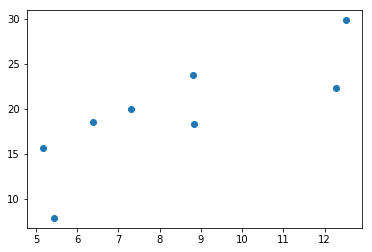

In [49]:
# 來看看產生x-y分佈是什麼樣的
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

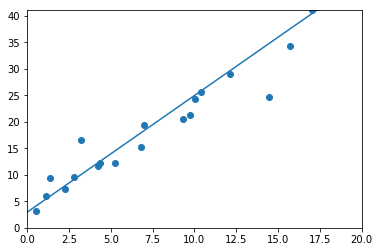

2.0188677310943604 2.8898627758026123


In [50]:
# 隨機初始化參數
w = V(t.rand(1,1), requires_grad=True)
b = V(t.zeros(1,1), requires_grad=True)

lr =0.001 # 學習率

for ii in range(8000):
    x, y = get_fake_data()
    x, y = V(x), V(y)
    
    # forward：計算loss
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()
    
    # backward：手動計算梯度
    loss.backward()
    
    # 更新參數
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if ii%1000 ==0:
        # 畫圖
        display.clear_output(wait=True)
        x = t.arange(0, 20).view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0,20)
        plt.ylim(0,41)   
        plt.show()
        plt.pause(0.5)
        
print(w.data.squeeze()[0], b.data.squeeze()[0])

用autograd實現的線性回歸最大的不同點就在於autograd不需要計算反向傳播，可以自動計算微分。這點不單是在深度學習，在許多機器學習的問題中都很有用。另外需要注意的是在每次反向傳播之前要記得先把梯度清零。

本章主要介紹了PyTorch中兩個基礎底層的資料結構：Tensor和autograd中的Variable。Tensor是一個類似Numpy陣列的高效多維數值運算資料結構，有著和Numpy相類似的介面，並提供簡單易用的GPU加速。Variable是autograd封裝了Tensor並提供自動求導技術的，具有和Tensor幾乎一樣的介面。`autograd`是PyTorch的自動微分引擎，採用動態計算圖技術，能夠快速高效的計算導數。